# AWS Lambda

AWSのFaaSサービス。

Bare Metal EC2（Worker）上のKernel Virtual Machines上で、数百～数千のFirecracker MicroVMsを起動し、その中で動かす。

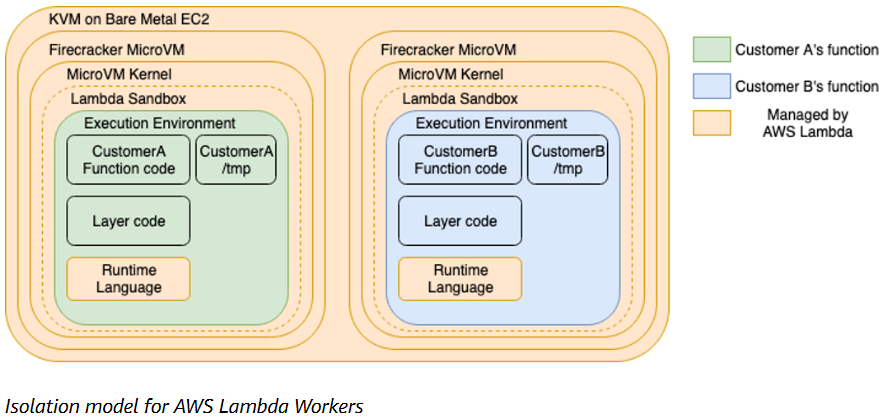

（出所：[AWS Whitepaper: Security Overview of AWS Lambda](https://docs.aws.amazon.com/pdfs/whitepapers/latest/security-overview-aws-lambda/security-overview-aws-lambda.pdf)）


## Firecracker

Linux Kernel-based Virtual Machine (KVM)を使ってmicroVMsを作り、管理するためのツール（virtual machine monitor: VMM）。

AWS LambdaやAWS Fargateで使われている。

Dockerのようなコンテナ仮想化技術はホストマシンのカーネルを複数のコンテナで共有しており、コンテナ間で環境が完全には分離されない。
AWS側が安全にサービスを提供するにあたって環境の分離が必要になり、Firecrackerが開発された。


ハイパーバイザにあたる（[知らなくても困らないけど、知ると楽しいAWS Lambdaの裏側の世界 #devio2021 - YouTube](https://www.youtube.com/watch?v=Y8UXki_TQPk)）


:::{admonition} 参考文献
:class: info

- 公式サイト：https://firecracker-microvm.github.io/
- AWSのブログ：[Firecracker – サーバーレスコンピューティングのための軽量な仮想化機能](https://aws.amazon.com/jp/blogs/news/firecracker-lightweight-virtualization-for-serverless-computing/)
- 学会発表時の資料と動画: [Firecracker: Lightweight Virtualization for Serverless Applications | USENIX](https://www.usenix.org/conference/nsdi20/presentation/agache)
- 日本語解説記事：[Lambdaの裏側を知りたい人にオススメ Firecrackerに関する論文「Firecracker: Lightweight Virtualization for Serverless Applications」の紹介 | DevelopersIO](https://dev.classmethod.jp/articles/firecracker-lightweight-virtualization-for-serverless-applications/)
:::

## デプロイ方法ごとの特色

### zipでのデプロイをしたときの扱い

少なくともコンテナイメージでのデプロイをサポートする前は、zipをS3からダウンロードしてMicroVM上に展開していたらしい。

> In the first generation architecture (before this work), when a new MicroVM is created with new capacity for a particular function, the Worker downloads the function image (a .zip file up to 250MiB in size) from Amazon S3, and unpacks it into the MicroVM guest’s filesystem.
> ([Brooker, et al., 2023](https://arxiv.org/pdf/2305.13162))

コンテナイメージをサポート後もzipデプロイ時のシステムは同様なのかはよくわからなかった。パッケージサイズが大きくなったときにimageほどinit Durationが短くないので、以前と変わらない方法をとっていそう。


[AWS Lambdaのコールドスタートはコンテナイメージを使うと悪化するのか｜Masayoshi Mita](https://note.com/kind_ixia1/n/n10ee12d0856b?magazine_key=m56c4309d8dc6)

### コンテナイメージでデプロイした場合

- 512KiBごとのチャンクに分割して重複削除してキャッシュするので、見た目のサイズより高速になる
- 公式のベースイメージだとインスタンスに近いところにキャッシュがあったり、すでにWorkerにロードされてたりするのでinitが高速


## コンテナ読み込みを支える技術


### 重複削除

- 多くのイメージは同じ内容を含む：Lambda利用者のコンテナイメージの約75%は、ユニークなバイトが5%未満
- 重複を削除して効率的にキャッシュを作る
- 単一のフラット ファイル システムに展開し、そのファイル システムを 512KiB のチャンクに分割する。次に、チャンクをハッシュして一意のコンテンツを識別し、キャッシュ レイヤーに同じデータのコピーが多すぎるのを回避

:::{admonition} Brooker et al. (2023). On-demand Container Loading in AWS Lambda
:class: info

Brooker, M., Danilov, M., Greenwood, C., & Piwonka, P. (2023). On-demand Container Loading in AWS Lambda. In 2023 USENIX Annual Technical Conference (USENIX ATC 23) (pp. 315-328).

- [ATC '23](https://www.usenix.org/conference/atc23/presentation/brooker) (paper & video)
- [arxiv.org/pdf/2305.13162](https://arxiv.org/pdf/2305.13162) (paper)
- [Container Loading in AWS Lambda - Marc's Blog](https://brooker.co.za/blog/2023/05/23/snapshot-loading.html) (Brookerのブログでの解説)
:::

:::{admonition} Deep dive into AWS Lambda security: Function isolation (re:Invent 2021)
:class: info

- video：https://www.youtube.com/watch?v=FTwsMYXWGB0
- Classmethodの解説ブログ：[[セッションレポート]Lambdaのコンテナイメージ管理の裏側に詳しくなれるセッション SVS404 Deep dive into AWS Lambda security: Function isolation #reinvent | DevelopersIO](https://dev.classmethod.jp/articles/reinvent2020-svs404/)
:::

[知らなくても困らないけど、知ると楽しいAWS Lambdaの裏側の世界 #devio2021 - YouTube](https://www.youtube.com/watch?v=Y8UXki_TQPk)

## Lambdaの最適化

### 公式ベースイメージを使う

公式ベースイメージは見かけ以上に高速に読み込まれる

個人的には経験上これは感じていたが、実際にAWSのブログにも書かれている

[Optimizing Lambda functions packaged as container images | AWS Compute Blog](https://aws.amazon.com/jp/blogs/compute/optimizing-lambda-functions-packaged-as-container-images/)

の「Use AWS-provided base images」の部分には以下のようなことが書かれている。

> たとえば、AWS が提供する Go ランタイム `public.ecr.aws/lambda/go:1` のベースイメージは 670 MB あり、alpine:latest はわずか 5.58 MB です。ただし、AWS が提供するベースイメージを使用すると、3 つの利点があります。
>
> 1. キャッシュにより高速：AWS が提供するベースイメージは、Lambda サービスによってプロアクティブにキャッシュされます。これは、ベース イメージが近くの別の上流キャッシュにあるか、すでにワーカー インスタンス キャッシュに存在することを意味します。はるかに大きいにもかかわらず、キャッシュされない可能性があるサードパーティの基本イメージと比較すると、展開時間は依然として短い可能性があります。


### initフェーズはメモリ割当を増やしても高速化しない

boostされてるらしい

[LambdaのINITフェーズではメモリ128MでもCPUパワーをフルに使える？！boost host CPUの動きを確認してみた | DevelopersIO](https://dev.classmethod.jp/articles/lambda-boost-host-cpu-in-init-phase/)

## セキュリティ

microVMsの中にGuest Kernelもあり、ホストマシンと環境が分離されている


:::{admonition} Lambdaのセキュリティ関係の参考文献
:class: info

- [AWS Whitepaper: Security Overview of AWS Lambda](https://docs.aws.amazon.com/pdfs/whitepapers/latest/security-overview-aws-lambda/security-overview-aws-lambda.pdf)
- re:Invent 2020のSVS404（日本語解説記事：[[セッションレポート]Lambdaのコンテナイメージ管理の裏側に詳しくなれるセッション SVS404 Deep dive into AWS Lambda security: Function isolation #reinvent | DevelopersIO](https://dev.classmethod.jp/articles/reinvent2020-svs404/)）
:::

## 参考



### Lambda関係の論文

- [Agache et al. (2020). Firecracker: Lightweight virtualization for serverless applications.](https://www.usenix.org/conference/nsdi20/presentation/agache)
- [Brooker et al. (2023). On-demand Container Loading in {AWS} Lambda.](https://arxiv.org/pdf/2305.13162)


### re: Invent

:::{admonition} A closer look at AWS Lambda (re: Invent 2022, SVS404-R)
:class: info

- Slide: [A closer look at AWS Lambda (SVS404-R)](https://d1.awsstatic.com/events/Summits/reinvent2022/SVS404-R_A-closer-look-at-AWS-Lambda.pdf)
- Video: [AWS re:Invent 2022 - A closer look at AWS Lambda (SVS404-R) - YouTube](https://www.youtube.com/watch?v=0_jfH6qijVY)
- 日本語解説記事：[[2022年最新版]Lambdaの裏側教えます！！A closer look at AWS Lambda (SVS404-R) #reinvent | DevelopersIO](https://dev.classmethod.jp/articles/reinvent2020-session-svs404/)
:::

:::{admonition} Deep dive into AWS Lambda security: Function isolation (re: Invent 2020, SVS404)
:class: info

- Slide: https://d1.awsstatic.com/events/reinvent/2020/Deep_dive_into_AWS_Lambda_security_Function_isolation_SVS404.pdf
- Video: [AWS re:Invent 2020: Deep dive into AWS Lambda security: Function isolation - YouTube](https://www.youtube.com/watch?v=FTwsMYXWGB0)
- 日本語解説記事：[[セッションレポート]Lambdaのコンテナイメージ管理の裏側に詳しくなれるセッション SVS404 Deep dive into AWS Lambda security: Function isolation #reinvent | DevelopersIO](https://dev.classmethod.jp/articles/reinvent2020-svs404/)

:::


:::{admonition} A Serverless Journey: AWS Lambda Under the Hood (re: Invent 2019, SVS405)
:class: info

日本語解説記事：[Lambdaの内部アーキテクチャ教えます！A serverless journey: AWS Lambda under the hood #SVS405 #reinvent | DevelopersIO](https://dev.classmethod.jp/articles/reinvent2019-svs405/)
:::


:::{admonition} A Serverless Journey: AWS Lambda Under the Hood (re: Invent 2018, SRV409)
:class: info

日本語解説記事：[2019年VPC Lambdaが高速に！！ AWS Lambdaの内部構造に迫るセッション 「SRV409 A Serverless Journey: AWS Lambda Under the Hood」 #reinvent | DevelopersIO](https://dev.classmethod.jp/articles/reinvent2018-srv409/)
:::
